In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.fft import fft, fftfreq
from pysid import bj, armax, oe, arma, ar, arx
from scipy.signal import find_peaks, dlti, dlsim
from scipy.stats import pearsonr
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.signal import dlti, dlsim

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Badly conditioned filter coefficients*")

In [3]:
df=pd.read_csv('D2.csv')
df.head()

,t,u,y,uv,yv
0,0.00,5.000000,0.000000,2.5,0.000000
1,0.01,5.199987,0.267089,2.5,0.217950
2,0.02,5.399893,0.441045,2.5,0.340503
3,0.03,5.599640,0.393459,2.5,0.239307
4,0.04,5.799147,0.338335,2.5,0.128421


In [4]:
t  = np.array(df.t)
u  = np.array(df.u)
y  = np.array(df.y)
uv  = np.array(df.uv)
yv  = np.array(df.yv)

Ts = np.mean(np.diff(t))

print(f"Período de muestreo Ts = {Ts} segundos")
print(f"Tiempo: {t.shape}, Entrada: {u.shape}, Salida: {y.shape}, Entrada1: {uv.shape}, Salida2: {yv.shape}")

Período de muestreo Ts = 0.01 segundos
Tiempo: (6001,), Entrada: (6001,), Salida: (6001,), Entrada1: (6001,), Salida2: (6001,)


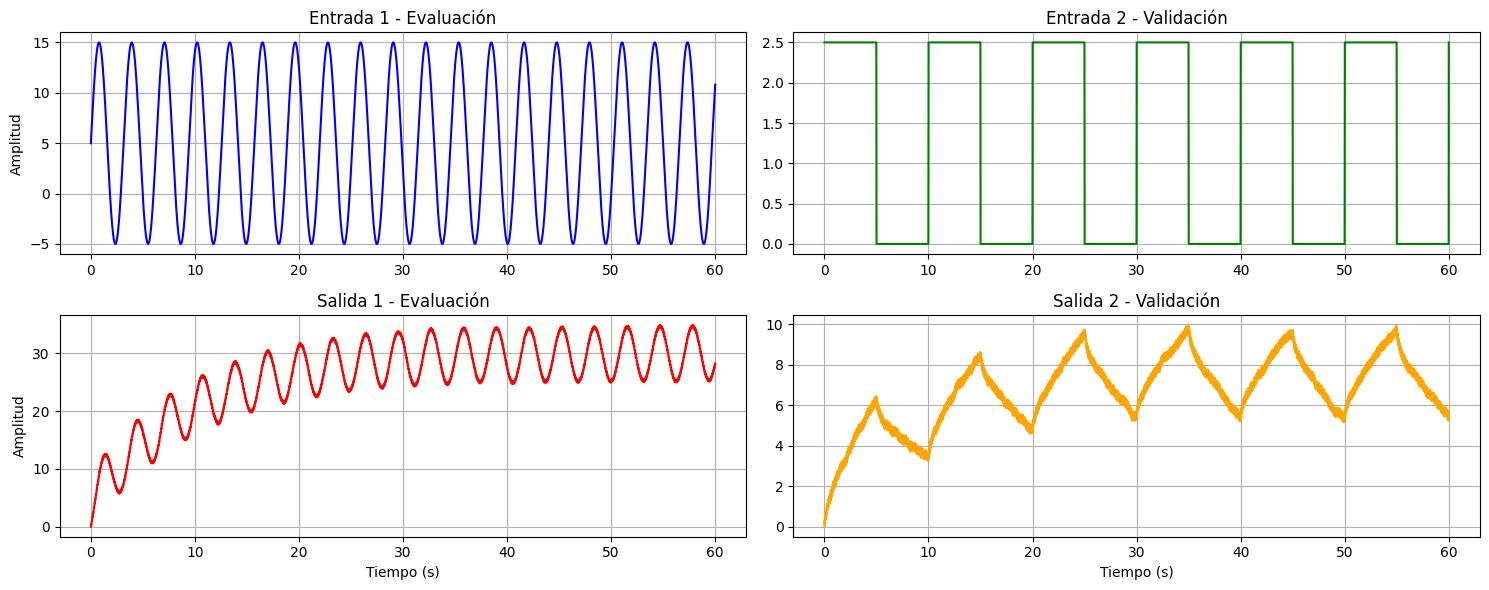

In [5]:
#VISUALIZACIÓN DE LA SEÑAL

plt.figure(figsize=(15, 6))

# Entrada evaluación
plt.subplot(2, 2, 1)
plt.plot(t, u, color='blue')
plt.title("Entrada 1 - Evaluación")
plt.ylabel("Amplitud")
plt.grid(True)

# Entrada validación
plt.subplot(2, 2, 2)
plt.plot(t, uv, color='green')
plt.title("Entrada 2 - Validación")
plt.grid(True)

# Salida evaluación
plt.subplot(2, 2, 3)
plt.plot(t, y, color='red')
plt.title("Salida 1 - Evaluación")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)

# Salida validación
plt.subplot(2, 2, 4)
plt.plot(t, yv, color='orange')
plt.title("Salida 2 - Validación")
plt.xlabel("Tiempo (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

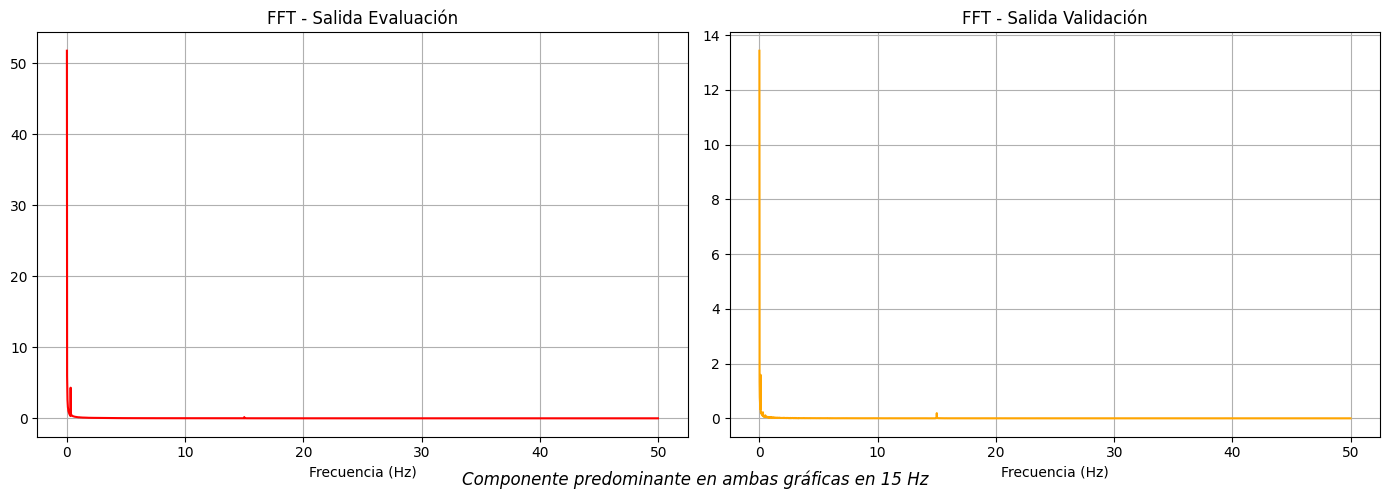

In [6]:
# ANÁLISIS FRECUENCIAL PARA IDENTIFICAR RUIDO

Ts = np.mean(np.diff(t))

N_eval = len(y)
yf_eval = fft(y)
xf_eval = fftfreq(N_eval, Ts)[:N_eval//2]

N_val = len(yv)
yf_val = fft(yv)
xf_val = fftfreq(N_val, Ts)[:N_val//2]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_eval, 2.0/N_eval * np.abs(yf_eval[0:N_eval//2]), color='red')
plt.title("FFT - Salida Evaluación")
plt.xlabel("Frecuencia (Hz)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_val, 2.0/N_val * np.abs(yf_val[0:N_val//2]), color='orange')
plt.title("FFT - Salida Validación")
plt.xlabel("Frecuencia (Hz)")
plt.grid(True)

plt.tight_layout()
plt.figtext(0.5, 0.02, "Componente predominante en ambas gráficas en 15 Hz", ha="center", fontsize=12, style='italic')
plt.show()

======================= ARX Modelo 1 =======================
Parámetros: na = 2, nb = 2, nk = 1
Coeficientes A: [ 1.         -1.57228235  0.57306895]
Coeficientes B: [ 0.          2.59704415 -5.0845988   2.49199765] 

======================= ARX Modelo 2 =======================
Parámetros: na = 3, nb = 2, nk = 1
Coeficientes A: [ 1.         -2.11251151  2.05382299 -0.94043069]
Coeficientes B: [ 0.         -3.41262197  7.03206109 -3.61415802] 

======================= ARX Modelo 3 =======================
Parámetros: na = 3, nb = 3, nk = 1
Coeficientes A: [ 1.         -2.11269781  2.05384147 -0.94025811]
Coeficientes B: [ 0.00000000e+00 -4.73376400e+09  1.41993986e+10 -1.41993986e+10
  4.73376400e+09] 



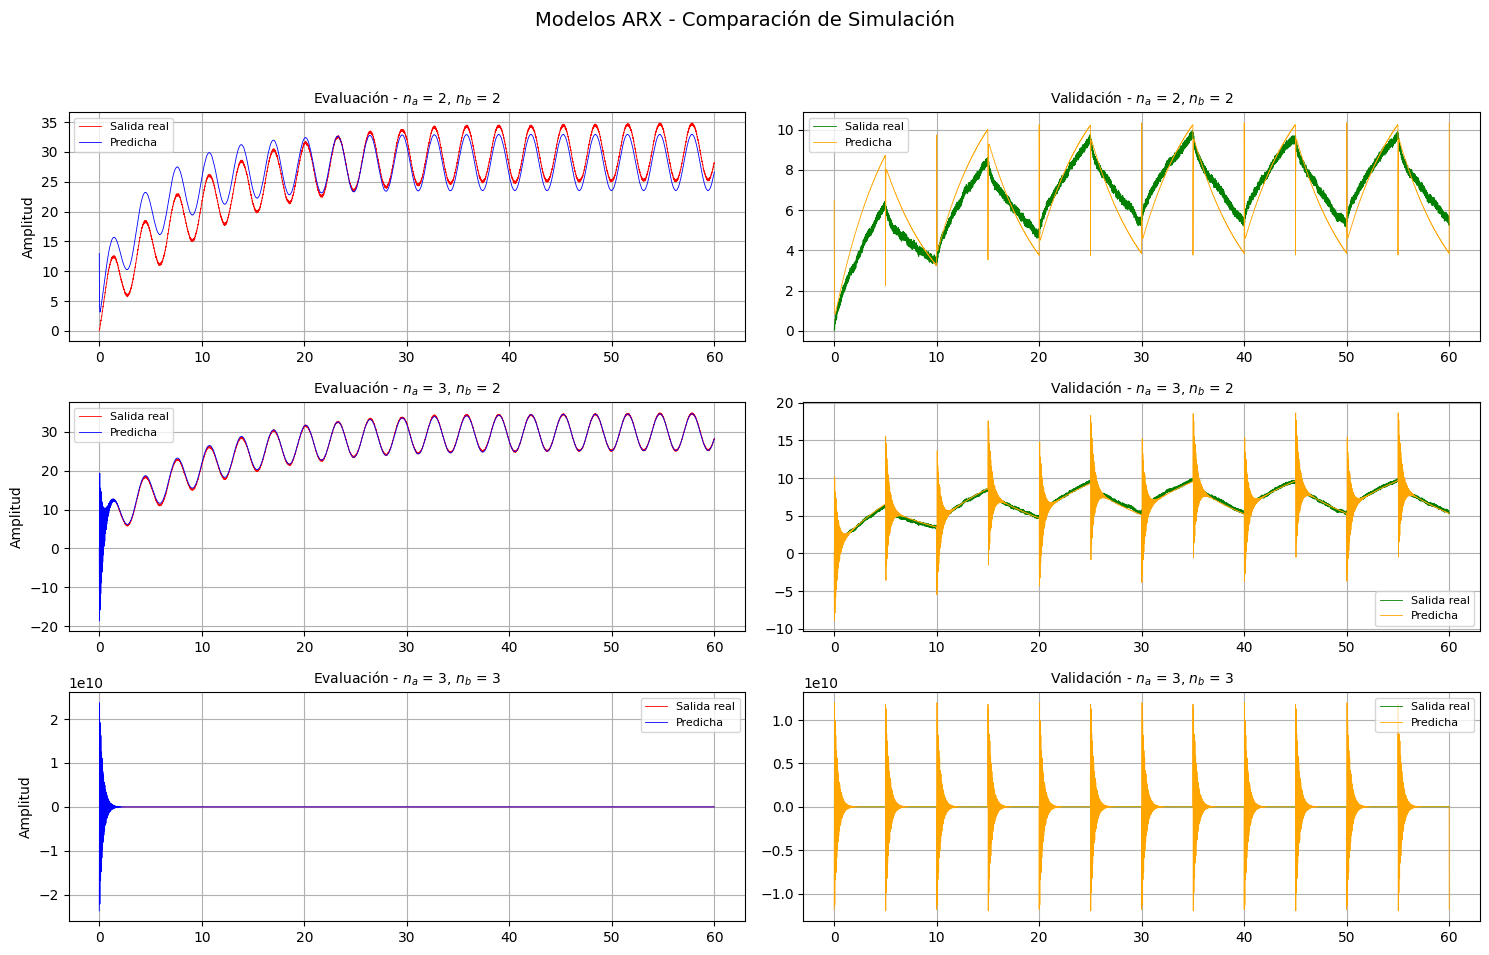

In [7]:
# Configuración de modelos: [na, nb, nk]
configuraciones_arx = [[2, 2, 1], [3, 2, 1], [3, 3, 1]]

# Listas para almacenar salidas simuladas
salidas_arx_entrenamiento = []
salidas_arx_validacion = []

# Ruido artificial con frecuencia de 15 Hz
frecuencia_ruido = 15
amplitud_ruido = 0.02
señal_ruido = amplitud_ruido * np.sin(2 * np.pi * frecuencia_ruido * t)

# Iterar sobre las configuraciones de modelo ARX
for indice, (orden_na, orden_nb, retardo_nk) in enumerate(configuraciones_arx):
    print(f"{' ARX Modelo ' + str(indice+1) + ' ':=^60}")
    print(f"Parámetros: na = {orden_na}, nb = {orden_nb}, nk = {retardo_nk}")

    modelo_arx = arx(orden_na, orden_nb, retardo_nk, u, y)

    A_coef = modelo_arx.A[0, 0]
    B_coef = modelo_arx.B[0, 0]

    print("Coeficientes A:", A_coef)
    print("Coeficientes B:", B_coef, "\n")

    # Crear sistema discreto con los coeficientes
    sistema_discreto = dlti(B_coef, A_coef, dt=Ts)

    # Simulación con datos de entrenamiento
    _, salida_entrenamiento = dlsim(sistema_discreto, u)
    salida_entrenamiento = salida_entrenamiento.flatten() + señal_ruido
    salidas_arx_entrenamiento.append(salida_entrenamiento)

    # Simulación con datos de validación
    _, salida_validacion = dlsim(sistema_discreto, uv)
    salida_validacion = salida_validacion.flatten() + señal_ruido
    salidas_arx_validacion.append(salida_validacion)

plt.figure(figsize=(15, 10))
plt.suptitle("Modelos ARX - Comparación de Simulación", fontsize=14)

for i in range(3):
    na_i, nb_i, _ = configuraciones_arx[i]

    # Simulación con datos de evaluación (izquierda)
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(t, y, label='Salida real', color='red', linewidth=0.6)
    plt.plot(t, salidas_arx_entrenamiento[i], label='Predicha', color='blue', linewidth=0.6)
    plt.title(f"Evaluación - $n_a$ = {na_i}, $n_b$ = {nb_i}", fontsize=10)
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.legend(fontsize=8)

    # Simulación con datos de validación (derecha)
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(t, yv, label='Salida real', color='green', linewidth=0.6)
    plt.plot(t, salidas_arx_validacion[i], label='Predicha', color='orange', linewidth=0.6)
    plt.title(f"Validación - $n_a$ = {na_i}, $n_b$ = {nb_i}", fontsize=10)
    plt.grid(True)
    plt.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

======================Modelo ARMAX #1=======================
Parámetros usados: na=2, nb=2, nc=2, nk=1
Coef A: [ 1.         -1.31899208  0.31998872]
Coef B: [ 0.          0.08507534 -0.02728122 -0.05222769]
Coef C: [1.         1.06626367 0.60487715]

======================Modelo ARMAX #2=======================
Parámetros usados: na=3, nb=2, nc=2, nk=1
Coef A: [ 1.         -2.1716308   2.16674697 -0.99395615]
Coef B: [ 0.          0.12564664 -0.0801898  -0.03873325]
Coef C: [ 1.         -0.82173204  0.58106648]

======================Modelo ARMAX #3=======================
Parámetros usados: na=3, nb=3, nc=2, nk=1


C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pysid\identification\solvers.py:67: LinAlgWarning: Ill-conditioned matrix (rcond=5.66731e-25): result may not be accurate.
  theta = solve(R1, R2)


Coef A: [ 1.         -2.17399526  2.1736477  -0.99849876]
Coef B: [ 0.          0.21216684 -0.42129593  0.38682892 -0.17100272]
Coef C: [ 1.         -1.09006127  0.92147228]



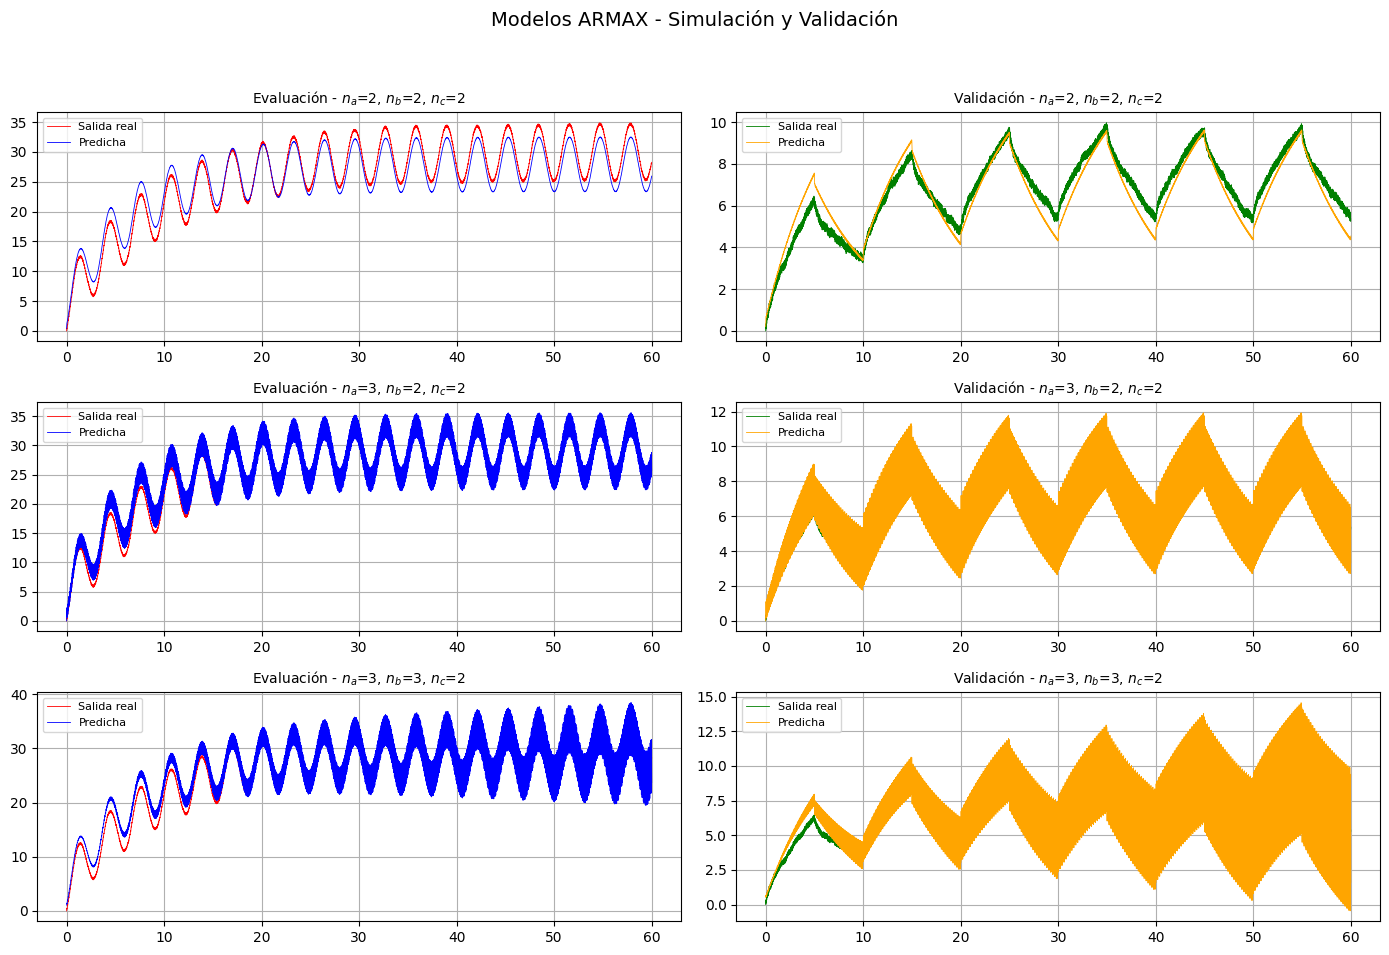

In [ ]:
# Parámetros para el modelo ARMAX
config_armax = [[2, 2, 2, 1], [3, 2, 2, 1], [3, 3, 2, 1]]

# Arreglos donde se guardarán las simulaciones
salidas_entrenamiento = []
salidas_validacion = []

# Generación de componente de ruido
freq_ruido = 15  # Hz
amp_ruido = 0.02
ruido_modelo = amp_ruido * np.sin(2 * np.pi * freq_ruido * t)

# Construcción de modelos ARMAX
for idx, (orden_na, orden_nb, orden_nc, retardo) in enumerate(config_armax):
    print(f"{'Modelo ARMAX #' + str(idx+1):=^60}")
    print(f"Parámetros usados: na={orden_na}, nb={orden_nb}, nc={orden_nc}, nk={retardo}")

    modelo_actual = armax(orden_na, orden_nb, orden_nc, retardo, u, y)

    A = modelo_actual.A[0, 0]
    B = modelo_actual.B[0, 0]
    C = modelo_actual.C[0, 0]

    print(f"Coef A: {A}")
    print(f"Coef B: {B}")
    print(f"Coef C: {C}\n")

    # Sistemas para señal + ruido
    sistema_salida = dlti(B, A, dt=Ts)
    sistema_error = dlti(C, A, dt=Ts)

    # Simulación con datos de entrenamiento
    _, respuesta_modelo = dlsim(sistema_salida, u)
    _, respuesta_error = dlsim(sistema_error, ruido_modelo)

    y_sim = respuesta_modelo.flatten()
    err_sim = respuesta_error.flatten()
    salida_final_entrenamiento = y_sim + err_sim
    salidas_entrenamiento.append(salida_final_entrenamiento)

    # Simulación con datos de validación
    _, salida_val = dlsim(sistema_salida, uv)
    salida_val = salida_val.flatten() + err_sim  # mismo error en validación
    salidas_validacion.append(salida_val)

# Visualización 
plt.figure(figsize=(14, 10))
plt.suptitle("Modelos ARMAX - Simulación y Validación", fontsize=14)

for i in range(3):
    na_i, nb_i, nc_i, _ = config_armax[i]

    # Panel izquierdo: entrenamiento
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(t, y, color='red', linewidth=0.6, label='Salida real')
    plt.plot(t, salidas_entrenamiento[i], color='blue', linewidth=0.6, label='Predicha')
    plt.title(f"Evaluación - $n_a$={na_i}, $n_b$={nb_i}, $n_c$={nc_i}", fontsize=10)
    plt.grid(True)
    plt.legend(fontsize=8)

    # Panel derecho: validación
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(t, yv, color='green', linewidth=0.6, label='Salida real')
    plt.plot(t, salidas_validacion[i], color='orange', linewidth=0.6, label='Predicha')
    plt.title(f"Validación - $n_a$={na_i}, $n_b$={nb_i}, $n_c$={nc_i}", fontsize=10)
    plt.grid(True)
    plt.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


========================Modelo OE #1========================
nb = 1, nf = 2, nk = 1
Coef B (ajustado): [ 0.0234695  -0.02307389]
Coef F: [ 1.         -1.93514321  0.93520897]

========================Modelo OE #2========================
nb = 3, nf = 2, nk = 1
Coef B (ajustado): [-1.01231562  2.37275878 -1.64495294  0.28585224]
Coef F: [ 1.         -1.78111485  0.78133766]

========================Modelo OE #3========================
nb = 3, nf = 3, nk = 1
Coef B (ajustado): [-0.59628024  0.25558406  1.38888691 -1.04569187]
Coef F: [ 1.         -1.72313938  0.85333905 -0.129785  ]



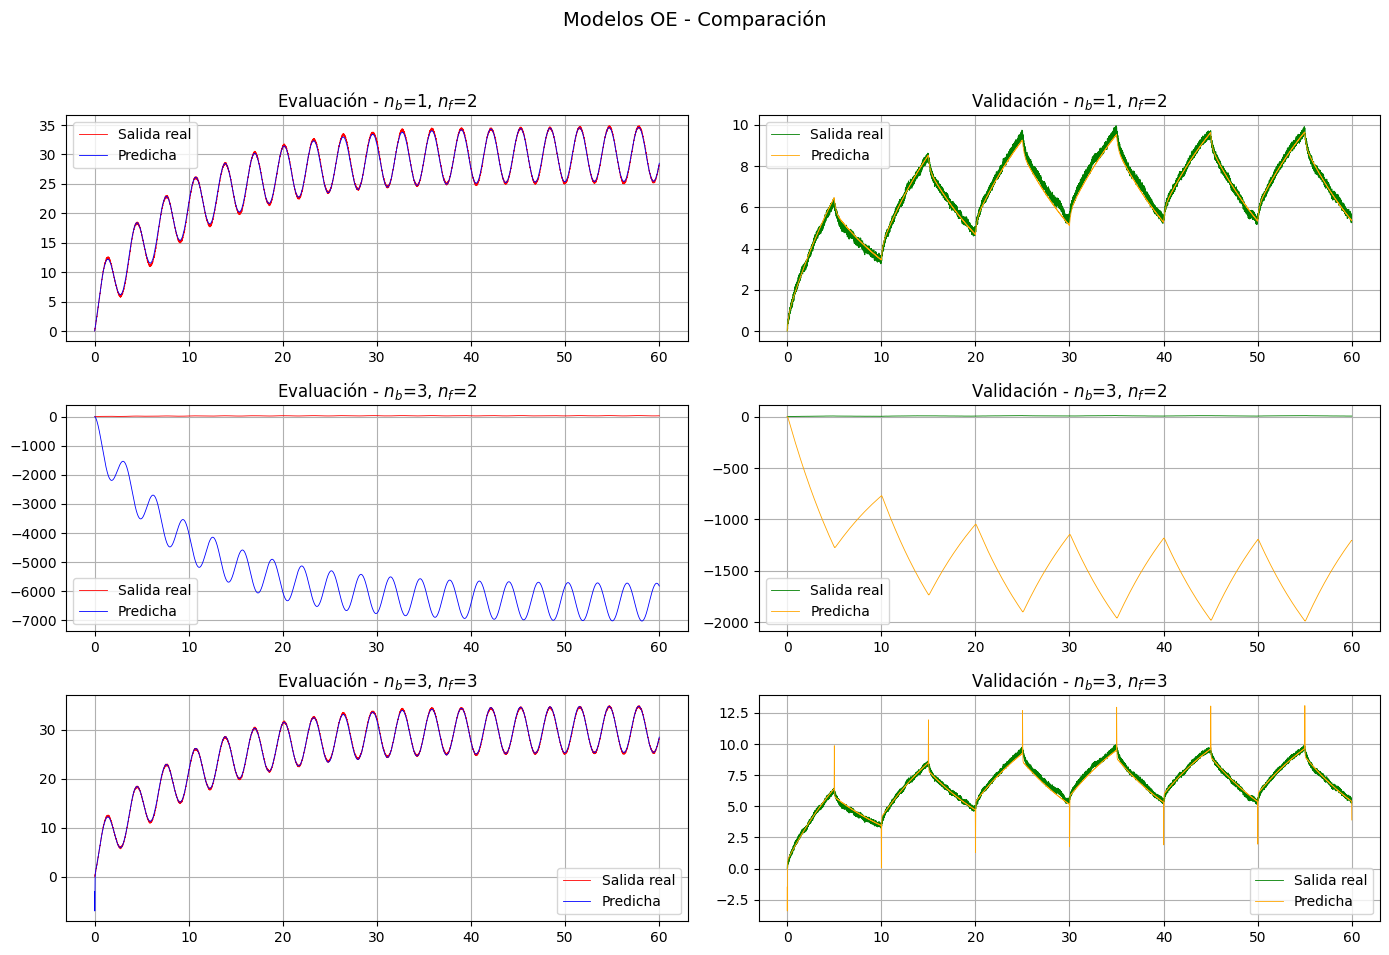

In [9]:
# Configuraciones: nb, nf, nk
config_oe = [[1, 2, 1], [3, 2, 1], [3, 3, 1]]

sim_oe_entreno = []
sim_oe_valida = []

# Simulación del ruido
f_ruido = 15  # Hz
a_ruido = 0.02
ruido = a_ruido * np.sin(2 * np.pi * f_ruido * t)

# Bucle de modelos OE
for idx, (nb_val, nf_val, nk_val) in enumerate(config_oe):
    print(f"{'Modelo OE #' + str(idx+1):=^60}")
    print(f"nb = {nb_val}, nf = {nf_val}, nk = {nk_val}")

    # Ajuste del modelo OE
    modelo = oe(nb_val, nf_val, nk_val, u, y)

    B_full = modelo.B[0, 0]
    F = modelo.F[0, 0]

    # Eliminar ceros iniciales del retardo nk
    B = B_full[nk_val:]  # Eliminar ceros por nk si los hay

    print(f"Coef B (ajustado): {B}")
    print(f"Coef F: {F}\n")

    # Validación de longitud
    if len(B) > len(F):
        # Truncar B para que tenga misma longitud que F
        B = B[:len(F)]

    # Sistema OE
    try:
        sistema = dlti(B, F, dt=Ts)

        # Simulación entrenamiento
        _, y_ent = dlsim(sistema, u)
        sim_oe_entreno.append(y_ent.flatten() + ruido)

        # Simulación validación
        _, y_val = dlsim(sistema, uv)
        sim_oe_valida.append(y_val.flatten() + ruido)

    except ValueError as e:
        print(f"Error al crear modelo OE #{idx+1}: {e}")
        sim_oe_entreno.append(np.full_like(y, np.nan))
        sim_oe_valida.append(np.full_like(yv, np.nan))

plt.figure(figsize=(14, 10))
plt.suptitle("Modelos OE - Comparación", fontsize=14)

for i in range(3):
    nb_i, nf_i, _ = config_oe[i]

    plt.subplot(3, 2, 2*i + 1)
    plt.plot(t, y, 'r', linewidth=0.6, label='Salida real')
    plt.plot(t, sim_oe_entreno[i], 'b', linewidth=0.6, label='Predicha')
    plt.title(f"Evaluación - $n_b$={nb_i}, $n_f$={nf_i}")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, 2*i + 2)
    plt.plot(t, yv, 'g', linewidth=0.6, label='Salida real')
    plt.plot(t, sim_oe_valida[i], 'orange', linewidth=0.6, label='Predicha')
    plt.title(f"Validación - $n_b$={nb_i}, $n_f$={nf_i}")
    plt.legend()
    plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

========================Modelo BJ #1========================
nb = 1, nc = 1, nd = 1, nf = 1, nk = 1
B: [ 0.          0.10065473 -0.09272765]
C: [1.         0.82119761]
D: [ 1.         -0.99439987]
F: [ 1.        -0.9986443]

========================Modelo BJ #2========================
nb = 2, nc = 1, nd = 1, nf = 2, nk = 1
B: [ 0.          0.09713931 -0.17683558  0.07992942]
C: [1.         0.79996736]
D: [ 1.         -0.86455078]
F: [ 1.         -1.96100582  0.96104451]

========================Modelo BJ #3========================
nb = 2, nc = 2, nd = 2, nf = 2, nk = 1
B: [ 0.          0.02981099 -0.02090866 -0.00798644]
C: [ 1.         -0.11053322 -0.82577527]
D: [ 1.         -1.55399044  0.55402355]
F: [ 1.         -1.87418256  0.87433619]



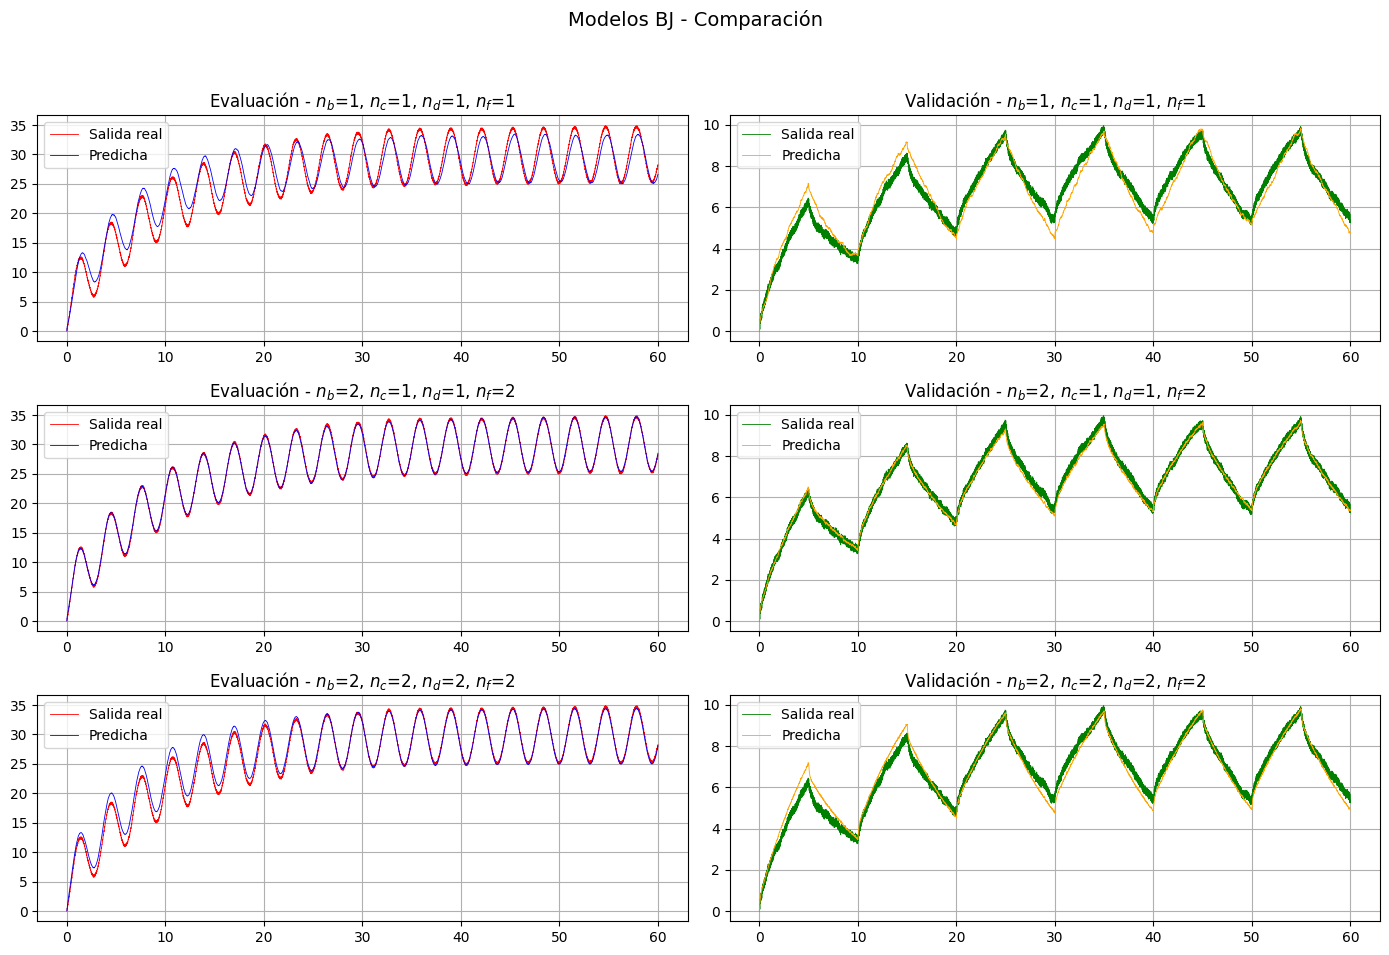

In [30]:
# Limpieza de datos
u = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
uv = np.nan_to_num(uv, nan=0.0, posinf=0.0, neginf=0.0)
yv = np.nan_to_num(yv, nan=0.0, posinf=0.0, neginf=0.0)

#Agregar esto para evitar el error
np.random.seed(0)
error = np.random.normal(0, 0.01, size=len(t))

error = np.nan_to_num(error, nan=0.0, posinf=0.0, neginf=0.0)

# Configuración de órdenes para BJ
config_bj = [
    [1, 1, 1, 1, 1],
    [2, 1, 1, 2, 1],
    [2, 2, 2, 2, 1],
]

sim_bj_entreno = []
sim_bj_valida = []

# Ruido de validación
f_ruido = 15  # Hz
a_ruido = 0.02
ruido = a_ruido * np.sin(2 * np.pi * f_ruido * t)

# Bucle de modelos BJ
for idx, (nb_val, nc_val, nd_val, nf_val, nk_val) in enumerate(config_bj):
    print(f"{'Modelo BJ #' + str(idx+1):=^60}")
    print(f"nb = {nb_val}, nc = {nc_val}, nd = {nd_val}, nf = {nf_val}, nk = {nk_val}")

    try:
        # Ajustar modelo BJ
        modelo = bj(nb_val, nc_val, nd_val, nf_val, nk_val, u, y)

        B = modelo.B[0, 0]
        C = modelo.C[0, 0]
        D = modelo.D[0, 0]
        F = modelo.F[0, 0]

        print(f"B: {B}")
        print(f"C: {C}")
        print(f"D: {D}")
        print(f"F: {F}\n")

        # Igualar longitudes para evitar errores
        if len(B) > len(F):
            F = np.append(F, [0] * (len(B) - len(F)))
        if len(C) > len(D):
            D = np.append(D, [0] * (len(C) - len(D)))

        # Sistemas
        sys_u = dlti(B, F, dt=Ts)
        sys_e = dlti(C, D, dt=Ts)

        # Simulación
        _, yb = dlsim(sys_u, u)
        _, eb = dlsim(sys_e, error)
        sim_bj_entreno.append((yb + eb).flatten() + ruido)

        _, ybv = dlsim(sys_u, uv)
        sim_bj_valida.append((ybv.flatten() + eb.flatten()) + ruido)

    except ValueError as e:
        print(f"Error en Modelo BJ #{idx+1}: {e}")
        sim_bj_entreno.append(np.full_like(y, np.nan))
        sim_bj_valida.append(np.full_like(yv, np.nan))

plt.figure(figsize=(14, 10))
plt.suptitle("Modelos BJ - Comparación", fontsize=14)

for i in range(3):
    nb_i, nc_i, nd_i, nf_i, nk_i = config_bj[i]

    plt.subplot(3, 2, 2*i + 1)
    plt.plot(t, y, 'r', linewidth=0.6, label='Salida real')
    plt.plot(t, sim_bj_entreno[i], 'b', linewidth=0.6, label='Predicha')
    plt.title(f"Evaluación - $n_b$={nb_i}, $n_c$={nc_i}, $n_d$={nd_i}, $n_f$={nf_i}")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, 2*i + 2)
    plt.plot(t, yv, 'g', linewidth=0.6, label='Salida real')
    plt.plot(t, sim_bj_valida[i], 'orange', linewidth=0.6, label='Predicha')
    plt.title(f"Validación - $n_b$={nb_i}, $n_c$={nc_i}, $n_d$={nd_i}, $n_f$={nf_i}")
    plt.legend()
    plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [13]:
#MÉTRICAS CUANTITATIVAS

def obtener_indicadores(real, estimada):
    real = np.ravel(real)
    estimada = np.ravel(estimada)

    mse_valor = np.mean((real - estimada)**2)
    mae_valor = np.mean(np.abs(real - estimada))
    correlacion, _ = pearsonr(real, estimada)

    return dict(MSE=mse_valor, MAE=mae_valor, Correlación=correlacion)

In [34]:
# Listas para guardar métricas
resultados_arx_train = []
resultados_arx_test = []

# Evaluación de las métricas para cada modelo ARX
for m in range(3):
    salida_train = salidas_arx_entrenamiento[m]
    salida_test = salidas_arx_validacion[m]

    metrica_train = obtener_indicadores(y, salida_train)
    metrica_test = obtener_indicadores(yv, salida_test)

    resultados_arx_train.append(metrica_train)
    resultados_arx_test.append(metrica_test)

# Impresión de resultados
print("\n>>> Indicadores Cuantitativos - Modelos ARX<<<")
for idx in range(3):
    print(f"\nModelo #{idx + 1}")
    print("[Evaluación]")
    for nombre, val in resultados_arx_train[idx].items():
        print(f"   {nombre}: {val:.4f}")
    print(" [Validación]")
    for nombre, val in resultados_arx_test[idx].items():
        print(f"   {nombre}: {val:.4f}")


>>> Indicadores Cuantitativos - Modelos ARX<<<

Modelo #1
[Evaluación]
   MSE: 5.5566
   MAE: 1.9631
   Correlación: 0.9587
 [Validación]
   MSE: 1.0020
   MAE: 0.7897
   Correlación: 0.8572

Modelo #2
[Evaluación]
   MSE: 0.7304
   MAE: 0.2727
   Correlación: 0.9922
 [Validación]
   MSE: 2.0751
   MAE: 0.5903
   Correlación: 0.7604

Modelo #3
[Evaluación]
   MSE: 1000976249616153984.0000
   MAE: 95677955.4913
   Correlación: 0.0044
 [Validación]
   MSE: 3145303081364600320.0000
   MAE: 581136094.7195
   Correlación: 0.0015


In [33]:
# Inicializar listas para almacenar las métricas
indicadores_armax_entrenamiento = []
indicadores_armax_validacion = []

# Evaluación de cada modelo ARMAX
for i in range(3):
    salida_entreno = salidas_entrenamiento[i]
    salida_valida = salidas_validacion[i]

    indicador_ent = obtener_indicadores(y, salida_entreno)
    indicador_val = obtener_indicadores(yv, salida_valida)

    indicadores_armax_entrenamiento.append(indicador_ent)
    indicadores_armax_validacion.append(indicador_val)

# Mostrar resultados en consola
print("\n>>> Indicadores Cuantitativos - Modelos ARMAX <<<")
for i in range(3):
    print(f"\nModelo ARMAX #{i + 1}")
    print("[Evaluación]")
    for nombre, valor in indicadores_armax_entrenamiento[i].items():
        print(f"    {nombre}: {valor:.4f}")
    print("[Validación]")
    for nombre, valor in indicadores_armax_validacion[i].items():
        print(f"    {nombre}: {valor:.4f}")


>>> Indicadores Cuantitativos - Modelos ARMAX <<<

Modelo ARMAX #1
[Evaluación]
    MSE: 2.9298
    MAE: 1.5778
    Correlación: 0.9839
[Validación]
    MSE: 0.4034
    MAE: 0.5335
    Correlación: 0.9404

Modelo ARMAX #2
[Evaluación]
    MSE: 4.1075
    MAE: 1.6932
    Correlación: 0.9583
[Validación]
    MSE: 2.5332
    MAE: 1.3859
    Correlación: 0.7045

Modelo ARMAX #3
[Evaluación]
    MSE: 6.6915
    MAE: 2.2366
    Correlación: 0.9270
[Validación]
    MSE: 5.5580
    MAE: 1.9194
    Correlación: 0.5460


In [28]:
# Listas para registrar los indicadores de rendimiento
evaluacion_oe_train = []
evaluacion_oe_test = []

# Recorrido por cada conjunto de salidas simuladas OE
for j in range(3):
    pred_train = sim_oe_entreno[j] 
    pred_test = sim_oe_valida[j]    

    # Cálculo de métricas con función personalizada
    indicadores_train = obtener_indicadores(y, pred_train)
    indicadores_test = obtener_indicadores(yv, pred_test)

    evaluacion_oe_train.append(indicadores_train)
    evaluacion_oe_test.append(indicadores_test)

# Visualización de resultados por consola
print("\n>>> Indicadores Cuantitativos - Modelos OE <<<")
for modelo in range(3):
    print(f"\nModelo OE #{modelo + 1}")
    print("[Evaluación]")
    for metrica, resultado in evaluacion_oe_train[modelo].items():
        print(f"   {metrica}: {resultado:.4f}")
    print("[Validación]")
    for metrica, resultado in evaluacion_oe_test[modelo].items():
        print(f"   {metrica}: {resultado:.4f}")




>>> Indicadores Cuantitativos - Modelos OE <<<

Modelo OE #1
[Evaluación]
   MSE: 0.0539
   MAE: 0.1887
   Correlación: 0.9995
[Validación]
   MSE: 0.0401
   MAE: 0.1624
   Correlación: 0.9944

Modelo OE #2
[Evaluación]
   MSE: 31980538.7410
   MAE: 5469.5596
   Correlación: -0.9511
[Validación]
   MSE: 2116042.5325
   MAE: 1407.0963
   Correlación: -0.9703

Modelo OE #3
[Evaluación]
   MSE: 0.0521
   MAE: 0.1598
   Correlación: 0.9994
[Validación]
   MSE: 0.0821
   MAE: 0.1809
   Correlación: 0.9871


In [35]:
# Listas para registrar los indicadores de rendimiento BJ
evaluacion_bj_train = []
evaluacion_bj_test = []

# Recorrido por cada conjunto de salidas simuladas BJ
for j in range(3):
    pred_train = sim_bj_entreno[j]
    pred_test = sim_bj_valida[j]

    # Cálculo de métricas con función personalizada
    indicadores_train = obtener_indicadores(y, pred_train)
    indicadores_test = obtener_indicadores(yv, pred_test)

    evaluacion_bj_train.append(indicadores_train)
    evaluacion_bj_test.append(indicadores_test)

# Visualización de resultados por consola
print("\n>>> Indicadores Cuantitativos - Modelos BJ <<<")
for modelo in range(3):
    print(f"\nModelo BJ #{modelo + 1}")
    print("[Evaluación]")
    for metrica, resultado in evaluacion_bj_train[modelo].items():
        print(f"   {metrica}: {resultado:.4f}")
    print("[Validación]")
    for metrica, resultado in evaluacion_bj_test[modelo].items():
        print(f"   {metrica}: {resultado:.4f}")



>>> Indicadores Cuantitativos - Modelos BJ <<<

Modelo BJ #1
[Evaluación]
   MSE: 2.1593
   MAE: 1.1992
   Correlación: 0.9823
[Validación]
   MSE: 0.2357
   MAE: 0.3978
   Correlación: 0.9618

Modelo BJ #2
[Evaluación]
   MSE: 0.0415
   MAE: 0.1654
   Correlación: 0.9996
[Validación]
   MSE: 0.0408
   MAE: 0.1632
   Correlación: 0.9942

Modelo BJ #3
[Evaluación]
   MSE: 0.7938
   MAE: 0.6466
   Correlación: 0.9958
[Validación]
   MSE: 0.1399
   MAE: 0.3007
   Correlación: 0.9767


In [20]:
# Organizar las métricas en un diccionario general
metricas_modelos = {
    'ARX': {'train': resultados_arx_train, 'val': resultados_arx_test},
    'ARMAX': {'train': indicadores_armax_entrenamiento, 'val': indicadores_armax_validacion},
    'OE': {'train': evaluacion_oe_train, 'val': evaluacion_oe_test},
    'BJ': {'train': evaluacion_bj_train, 'val': evaluacion_bj_test},
}

def seleccionar_modelo_optimo(data_metricas, metrica_clave='MSE', ponderacion=(0.5, 0.5)):
    peso_train, peso_val = ponderacion
    mejor_puntaje = np.inf if metrica_clave != 'Correlación' else -np.inf
    mejor_info = {'modelo': None, 'indice': -1, 'puntaje': None}

    for nombre, conjunto in data_metricas.items():
        for i in range(len(conjunto['train'])):
            val_train = conjunto['train'][i][metrica_clave]
            val_valid = conjunto['val'][i][metrica_clave]

            score = peso_train * val_train + peso_val * val_valid

            if (metrica_clave != 'Correlación' and score < mejor_puntaje) or \
               (metrica_clave == 'Correlación' and score > mejor_puntaje):
                mejor_puntaje = score
                mejor_info['modelo'] = nombre
                mejor_info['indice'] = i
                mejor_info['puntaje'] = score

    return mejor_info['modelo'], mejor_info['indice'], mejor_info['puntaje']


In [37]:
# Parámetros de ponderación (50% entrenamiento y 50% validación)
peso_ent = 0.5
peso_val = 0.5

# Evaluación por MSE
modelo_mse, idx_mse, val_mse = seleccionar_modelo_optimo(metricas_modelos, metrica_clave='MSE', ponderacion=(peso_ent, peso_val))
print(f"\nMejor modelo según MSE: {modelo_mse} - configuración #{idx_mse+1} - puntuación combinada = {val_mse:.5f}")

# Evaluación por MAE
modelo_mae, idx_mae, val_mae = seleccionar_modelo_optimo(metricas_modelos, metrica_clave='MAE', ponderacion=(peso_ent, peso_val))
print(f"Mejor modelo según MAE: {modelo_mae} - configuración #{idx_mae+1} - puntuación combinada = {val_mae:.5f}")

# Evaluación por Correlación
modelo_corr, idx_corr, val_corr = seleccionar_modelo_optimo(metricas_modelos, metrica_clave='Correlación', ponderacion=(peso_ent, peso_val))
print(f"Mejor modelo según Correlación: {modelo_corr} - configuración #{idx_corr+1} - puntuación combinada = {val_corr:.5f}")



Mejor modelo según MSE: OE - configuración #1 - puntuación combinada = 0.04701
Mejor modelo según MAE: OE - configuración #3 - puntuación combinada = 0.17033
Mejor modelo según Correlación: OE - configuración #1 - puntuación combinada = 0.99696
